In [7]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from apa_variant_prediction_utils import *

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from scipy.stats import ttest_ind

def load_data(isoform_pseudo_count=1., proximal_start=57, proximal_end=87, cse_inclusion_list=['AATAAA', 'ATTAAA'], upstream_cse_exlusion_list=[]) :
    
    #Load variant dataframe
    seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
    variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')

    #Load predictions (Resnet)
    model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'
    pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

    pred_dict['cut_prob'] = pred_dict['cut_prob'][:, 20:]

    #Join mpra dataframes with prediction table and calculate cut probabilities
    _, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'], proximal_start=proximal_start, proximal_end=proximal_end, isoform_pseudo_count=isoform_pseudo_count)

    variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

    included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

    filter_query = ""

    for exp_index, included_experiment in enumerate(included_experiments) :
        filter_query += "experiment == '" + str(included_experiment) + "'"
        if exp_index < len(included_experiments) - 1 :
            filter_query += " or "

    variant_df = variant_df_filtered.query(filter_query).copy()

    if cse_inclusion_list is not None and len(cse_inclusion_list) > 0 :
        variant_df = variant_df.loc[variant_df['master_seq'].str.slice(50, 56).isin(cse_inclusion_list)].copy()
        variant_df = variant_df.loc[variant_df['master_seq'].str.slice(50, 56) == variant_df['wt_seq'].str.slice(50, 56)].copy()
    
    if upstream_cse_exlusion_list is not None and len(upstream_cse_exlusion_list) > 0 :
        variant_df = variant_df.loc[~variant_df['wt_seq'].str.slice(0, 50).str.contains('|'.join(upstream_cse_exlusion_list))].copy()
        variant_df = variant_df.loc[~variant_df['master_seq'].str.slice(0, 50).str.contains('|'.join(upstream_cse_exlusion_list))].copy()

    print("n (variants) = " + str(len(variant_df)))
    
    return variant_df


In [8]:
#Load variant data

isoform_pseudo_count = 1.
proximal_start = 57
proximal_end = 87

cse_inclusion_list = [
    'AATAAA',
    'ATTAAA',
    'TATAAA',
    'CATAAA',
    'GATAAA',
    'AGTAAA',
    'ACTAAA',
    'AATACA',
    'AATAGA',
    'AATATA',
    'AATAAT',
    'AATAAC',
    'AATAAG',
    'AATGAA',
    'AATCAA',
]

upstream_cse_exlusion_list = [
    'AATAAA',
    'ATTAAA',
    'TATAAA',
    'CATAAA',
    'GATAAA',
    'AGTAAA',
    'ACTAAA',
    'AATACA',
    'AAAAAA',
    'AACAAA',
    'AAGAAA',
]

variant_df = load_data(
    isoform_pseudo_count=isoform_pseudo_count,
    proximal_start=proximal_start,
    proximal_end=proximal_end,
    cse_inclusion_list=cse_inclusion_list,
    upstream_cse_exlusion_list=upstream_cse_exlusion_list,
)


n (variants) = 7433


T-test Statistic = -4.974232595620018
T-test P-value = 3.1607569592470873e-06


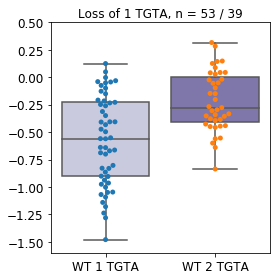

T-test Statistic = 0.9343402600497326
T-test P-value = 0.35035649701563476


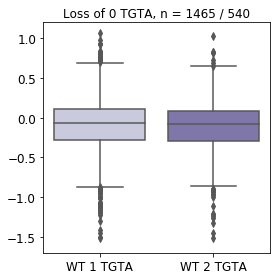

In [4]:
#Test hypothesis that 2 TGTA lessens the effect of loss of CFI binding motif

variant_df['ref_contains_0_upstream_tgta'] = (variant_df['wt_seq'].str.slice(0, 45).str.count("TGTA") == 0)
variant_df['ref_contains_1_upstream_tgta'] = (variant_df['wt_seq'].str.slice(0, 45).str.count("TGTA") == 1)
variant_df['ref_contains_2_upstream_tgta'] = (variant_df['wt_seq'].str.slice(0, 45).str.count("TGTA") == 2)

variant_df['var_contains_0_upstream_tgta'] = (variant_df['master_seq'].str.slice(0, 45).str.count("TGTA") == 0)
variant_df['var_contains_1_upstream_tgta'] = (variant_df['master_seq'].str.slice(0, 45).str.count("TGTA") == 1)
variant_df['var_contains_2_upstream_tgta'] = (variant_df['master_seq'].str.slice(0, 45).str.count("TGTA") == 2)

ref_1_var_0_upstream_tgta = np.array(variant_df.query("ref_contains_1_upstream_tgta == True and var_contains_0_upstream_tgta == True")['delta_logodds_true'].values)
ref_2_var_1_upstream_tgta = np.array(variant_df.query("ref_contains_2_upstream_tgta == True and var_contains_1_upstream_tgta == True")['delta_logodds_true'].values)

ref_1_var_1_upstream_tgta = np.array(variant_df.query("ref_contains_1_upstream_tgta == True and var_contains_1_upstream_tgta == True")['delta_logodds_true'].values)
ref_2_var_2_upstream_tgta = np.array(variant_df.query("ref_contains_2_upstream_tgta == True and var_contains_2_upstream_tgta == True")['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[ref_1_var_0_upstream_tgta, ref_2_var_1_upstream_tgta])

sns.boxplot(data=[ref_1_var_0_upstream_tgta, ref_2_var_1_upstream_tgta], palette='Purples')

plt.xticks([0, 1], ['WT 1 TGTA', 'WT 2 TGTA'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-1.6, 0.5)

n_1 = ref_1_var_0_upstream_tgta.shape[0]
n_2 = ref_2_var_1_upstream_tgta.shape[0]

s, p = ttest_ind(ref_1_var_0_upstream_tgta, ref_2_var_1_upstream_tgta, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 1 TGTA, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_tgta_saturation_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_tgta_saturation_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[ref_1_var_1_upstream_tgta, ref_2_var_2_upstream_tgta], palette='Purples')

plt.xticks([0, 1], ['WT 1 TGTA', 'WT 2 TGTA'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-1.7, 1.2)

n_1 = ref_1_var_1_upstream_tgta.shape[0]
n_2 = ref_2_var_2_upstream_tgta.shape[0]

s, p = ttest_ind(ref_1_var_1_upstream_tgta, ref_2_var_2_upstream_tgta, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 0 TGTA, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_tgta_saturation_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_tgta_saturation_boxplot_null.eps")

plt.show()


In [5]:
#Save dataframe with 2 TGTA variants

variant_df.query("ref_contains_2_upstream_tgta == True and var_contains_1_upstream_tgta == True").to_csv("apa_mpra_variants_tgta_saturation.csv", sep='\t', index=False)


T-test Statistic = 2.194150834582518
T-test P-value = 0.03637508578797572


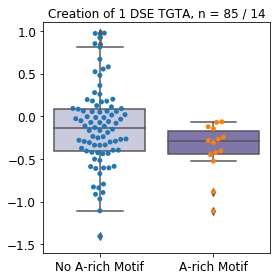

T-test Statistic = -0.4172600300143421
T-test P-value = 0.6765071142222481


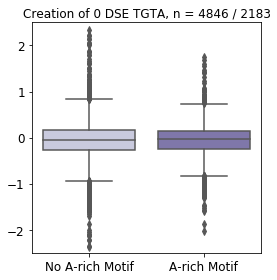

In [21]:
#Test hypothesis that creation of downstream TGTA is more repressive when coupled with A-rich motif

canonical_pas_motifs = [
    'AATAAA',
    'ATTAAA',
]

non_canonical_pas_motifs = [
    'TATAAA',
    'CATAAA',
    'GATAAA',
    'AGTAAA',
    'ACTAAA',
]

aa_motifs = [
    'AAAA',
    'AAAGA',
    'AAACA',
    'AGAAA',
    'ACAAA',
]

has_tgta_and_no_aa_ind = []
has_tgta_and_aa_ind = []

no_tgta_and_no_aa_ind = []
no_tgta_and_aa_ind = []

for index, row in variant_df.iterrows() :
    
    ref_seq = row['wt_seq']
    var_seq = row['master_seq']
    snv_pos = row['snv_pos']
    
    ref_dse = ref_seq[56:106]
    var_dse = var_seq[56:106]
    
    has_dse_pas = False
    for pas_motif in canonical_pas_motifs + non_canonical_pas_motifs :
        if pas_motif in ref_dse or pas_motif in var_dse :
            has_dse_pas = True
            break
    
    #if has_dse_pas :
    #    continue
    
    ref_contains_0_dse_tgta = ref_dse.count("TGTA") == 0
    ref_contains_1_dse_tgta = ref_dse.count("TGTA") == 1
    ref_contains_2_dse_tgta = ref_dse.count("TGTA") == 2
    
    var_contains_0_dse_tgta = var_dse.count("TGTA") == 0
    var_contains_1_dse_tgta = var_dse.count("TGTA") == 1
    var_contains_2_dse_tgta = var_dse.count("TGTA") == 2
    
    has_tgta_and_no_aa = False
    has_tgta_and_aa = False
    
    if (ref_contains_0_dse_tgta and var_contains_1_dse_tgta) or (ref_contains_1_dse_tgta and var_contains_2_dse_tgta) :
        
        var_fdse = var_seq[snv_pos + 15:snv_pos + 35]
        
        has_aa = False
        for aa_motif in aa_motifs :
            if aa_motif in var_fdse :
                has_aa = True
                break
        
        for aa_motif in canonical_pas_motifs + non_canonical_pas_motifs :
            if aa_motif in var_fdse :
                has_aa = True
                break
        
        if has_aa :
            has_tgta_and_aa = True
        else :
            has_tgta_and_no_aa = True
    
    if has_tgta_and_aa :
        has_tgta_and_aa_ind.append(index)
    elif has_tgta_and_no_aa :
        has_tgta_and_no_aa_ind.append(index)
    
    no_tgta_and_no_aa = False
    no_tgta_and_aa = False
    
    if (ref_contains_0_dse_tgta and var_contains_0_dse_tgta) or (ref_contains_1_dse_tgta and var_contains_1_dse_tgta) :
        
        var_fdse = var_seq[snv_pos + 15:snv_pos + 35]
        
        has_aa = False
        for aa_motif in aa_motifs :
            if aa_motif in var_fdse :
                has_aa = True
                break
        
        for aa_motif in canonical_pas_motifs + non_canonical_pas_motifs :
            if aa_motif in var_fdse :
                has_aa = True
                break
        
        if has_aa :
            no_tgta_and_aa = True
        else :
            no_tgta_and_no_aa = True
    
    if no_tgta_and_aa :
        no_tgta_and_aa_ind.append(index)
    elif no_tgta_and_no_aa :
        no_tgta_and_no_aa_ind.append(index)

has_tgta_and_no_aas = np.array(variant_df.loc[has_tgta_and_no_aa_ind]['delta_logodds_true'].values)
has_tgta_and_aas = np.array(variant_df.loc[has_tgta_and_aa_ind]['delta_logodds_true'].values)

no_tgta_and_no_aas = np.array(variant_df.loc[no_tgta_and_no_aa_ind]['delta_logodds_true'].values)
no_tgta_and_aas = np.array(variant_df.loc[no_tgta_and_aa_ind]['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[has_tgta_and_no_aas, has_tgta_and_aas])

sns.boxplot(data=[has_tgta_and_no_aas, has_tgta_and_aas], palette='Purples')

plt.xticks([0, 1], ['No A-rich Motif', 'A-rich Motif'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-1.6, 1.1)

n_1 = has_tgta_and_no_aas.shape[0]
n_2 = has_tgta_and_aas.shape[0]

s, p = ttest_ind(has_tgta_and_no_aas, has_tgta_and_aas, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Creation of 1 DSE TGTA, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_tgta_creation_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_tgta_creation_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[no_tgta_and_no_aas, no_tgta_and_aas], palette='Purples')

plt.xticks([0, 1], ['No A-rich Motif', 'A-rich Motif'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(-2.5, 2.5)

n_1 = no_tgta_and_no_aas.shape[0]
n_2 = no_tgta_and_aas.shape[0]

s, p = ttest_ind(no_tgta_and_no_aas, no_tgta_and_aas, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Creation of 0 DSE TGTA, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_tgta_creation_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_tgta_creation_boxplot_null.eps")

plt.show()


T-test Statistic = -3.6726850658515247
T-test P-value = 0.0005481034410001771


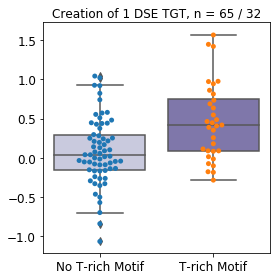

T-test Statistic = -1.3854617812046344
T-test P-value = 0.16628193806640582


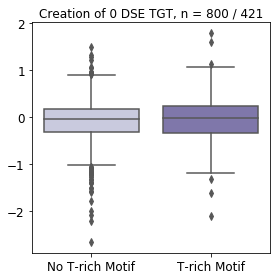

In [36]:
#Test hypothesis that creation of [G/C]T-rich motif is more enhancing near T-rich motif

t_motifs = [
    'TTTT',
    'TTATT',
    'TTCTT',
    'TATTT',
    'TCTTT',
    'TTTAT',
    'TTTCT',
]

has_tgt_and_no_t_ind = []
has_tgt_and_t_ind = []

no_tgt_and_no_t_ind = []
no_tgt_and_t_ind = []

for index, row in variant_df.iterrows() :
    
    ref_seq = row['wt_seq']
    var_seq = row['master_seq']
    snv_pos = row['snv_pos']
    
    ref_dse = ref_seq[56:106]
    var_dse = var_seq[56:106]
    
    has_dse_pas = False
    for pas_motif in cse_inclusion_list :
        if pas_motif in ref_dse or pas_motif in var_dse :
            has_dse_pas = True
            break
    
    if has_dse_pas :
        continue
    
    if snv_pos < 56 + 15 or snv_pos > 56 + 40 :
        continue
    
    ref_dse_tgt_count = ref_dse.count("TGT")
    var_dse_tgt_count = var_dse.count("TGT")
    
    ref_dse_tgt_count += ref_dse.count("GTCT")
    var_dse_tgt_count += var_dse.count("GTCT")
    
    ref_dse_ttt_count = ref_dse.count("TTT")
    var_dse_ttt_count = var_dse.count("TTT")
    
    has_tgt_and_no_t = False
    has_tgt_and_t = False
    
    if (ref_dse_tgt_count < var_dse_tgt_count) and (ref_dse_ttt_count == var_dse_ttt_count) :
        
        var_fdse = var_seq[snv_pos + 5:snv_pos + 20]
        
        has_t = False
        for t_motif in t_motifs :
            if t_motif in var_fdse :
                has_t = True
                break
        
        if has_t :
            has_tgt_and_t = True
        else :
            has_tgt_and_no_t = True
    
    if has_tgt_and_t :
        has_tgt_and_t_ind.append(index)
    elif has_tgt_and_no_t :
        has_tgt_and_no_t_ind.append(index)
    
    no_tgt_and_no_t = False
    no_tgt_and_t = False
    
    if (ref_dse_tgt_count == var_dse_tgt_count) :
        
        var_fdse = var_seq[snv_pos + 5:snv_pos + 20]
        
        has_t = False
        for t_motif in t_motifs :
            if t_motif in var_fdse :
                has_t = True
                break
        
        if has_t :
            no_tgt_and_t = True
        else :
            no_tgt_and_no_t = True
    
    if no_tgt_and_t :
        no_tgt_and_t_ind.append(index)
    elif no_tgt_and_no_t :
        no_tgt_and_no_t_ind.append(index)

has_tgt_and_no_ts = np.array(variant_df.loc[has_tgt_and_no_t_ind]['delta_logodds_true'].values)
has_tgt_and_ts = np.array(variant_df.loc[has_tgt_and_t_ind]['delta_logodds_true'].values)

no_tgt_and_no_ts = np.array(variant_df.loc[no_tgt_and_no_t_ind]['delta_logodds_true'].values)
no_tgt_and_ts = np.array(variant_df.loc[no_tgt_and_t_ind]['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[has_tgt_and_no_ts, has_tgt_and_ts])

sns.boxplot(data=[has_tgt_and_no_ts, has_tgt_and_ts], palette='Purples')

plt.xticks([0, 1], ['No T-rich Motif', 'T-rich Motif'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 1.1)

n_1 = has_tgt_and_no_ts.shape[0]
n_2 = has_tgt_and_ts.shape[0]

s, p = ttest_ind(has_tgt_and_no_ts, has_tgt_and_ts, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Creation of 1 DSE TGT, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_gt_rich_creation_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_gt_rich_creation_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[no_tgt_and_no_ts, no_tgt_and_ts], palette='Purples')

plt.xticks([0, 1], ['No T-rich Motif', 'T-rich Motif'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 1.1)

n_1 = no_tgt_and_no_ts.shape[0]
n_2 = no_tgt_and_ts.shape[0]

s, p = ttest_ind(no_tgt_and_no_ts, no_tgt_and_ts, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Creation of 0 DSE TGT, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_gt_rich_creation_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_gt_rich_creation_boxplot_null.eps")

plt.show()


T-test Statistic = 4.530478418035632
T-test P-value = 8.29530699181973e-05


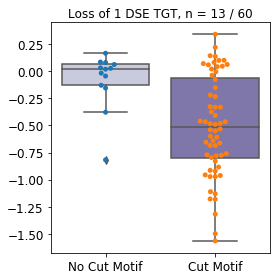

T-test Statistic = 1.1004402172186794
T-test P-value = 0.27178096870769586


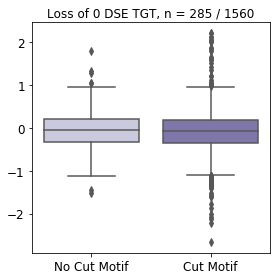

In [9]:
#Test hypothesis that loss of [G/C]T-rich motif is more severe downstream of cutsites

cut_motifs = [
    'CA',
    'GA',
    'TA',
]

has_tgt_and_no_cut_ind = []
has_tgt_and_cut_ind = []

no_tgt_and_no_cut_ind = []
no_tgt_and_cut_ind = []

for index, row in variant_df.iterrows() :
    
    ref_seq = row['wt_seq']
    var_seq = row['master_seq']
    snv_pos = row['snv_pos']
    
    ref_dse = ref_seq[56:96]
    var_dse = var_seq[56:96]
    
    has_dse_pas = False
    for pas_motif in cse_inclusion_list :
        if pas_motif in ref_dse or pas_motif in var_dse :
            has_dse_pas = True
            break
    
    #if has_dse_pas :
    #    continue
    
    if snv_pos < 56 + 15 or snv_pos > 56 + 40 :
        continue
    
    ref_dse_tgt_count = ref_dse.count("GTGT")
    var_dse_tgt_count = var_dse.count("GTGT")
    
    ref_dse_tgt_count += ref_dse.count("GTCT")
    var_dse_tgt_count += var_dse.count("GTCT")
    
    #ref_dse_first_tgt_count = min(ref_seq.find("GTGT") if ref_seq.find("GTGT") != -1 else 1000, ref_dse.find("GTCT") if ref_seq.find("GTCT") != -1 else 1000)
    #var_dse_first_tgt_count = min(var_dse.find("GTGT") if var_seq.find("GTGT") != -1 else 1000, var_dse.find("GTCT") if var_seq.find("GTCT") != -1 else 1000)
    
    has_tgt_and_no_cut = False
    has_tgt_and_cut = False
    
    if (ref_dse_tgt_count > 0 and var_dse_tgt_count == 0) :
    #if ((ref_dse_tgt_count > 0 and var_dse_tgt_count == 0) and (ref_dse_first_tgt_count != var_dse_first_tgt_count)) :
        
        var_fuse = var_seq[snv_pos-15:snv_pos-5]
        
        has_cut = False
        for cut_motif in cut_motifs :
            if cut_motif in var_fuse :
                has_cut = True
                break
        
        if has_cut :
            has_tgt_and_cut = True
        else :
            has_tgt_and_no_cut = True
    
    if has_tgt_and_cut :
        has_tgt_and_cut_ind.append(index)
    elif has_tgt_and_no_cut :
        has_tgt_and_no_cut_ind.append(index)
    
    no_tgt_and_no_cut = False
    no_tgt_and_cut = False
    
    if (ref_dse_tgt_count == var_dse_tgt_count) :
        
        var_fuse = var_seq[snv_pos-15:snv_pos-5]
        
        has_cut = False
        for cut_motif in cut_motifs :
            if cut_motif in var_fuse :
                has_cut = True
                break
        
        if has_cut :
            no_tgt_and_cut = True
        else :
            no_tgt_and_no_cut = True
    
    if no_tgt_and_cut :
        no_tgt_and_cut_ind.append(index)
    elif no_tgt_and_no_cut :
        no_tgt_and_no_cut_ind.append(index)

has_tgt_and_no_cuts = np.array(variant_df.loc[has_tgt_and_no_cut_ind]['delta_logodds_true'].values)
has_tgt_and_cuts = np.array(variant_df.loc[has_tgt_and_cut_ind]['delta_logodds_true'].values)

no_tgt_and_no_cuts = np.array(variant_df.loc[no_tgt_and_no_cut_ind]['delta_logodds_true'].values)
no_tgt_and_cuts = np.array(variant_df.loc[no_tgt_and_cut_ind]['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[has_tgt_and_no_cuts, has_tgt_and_cuts])

sns.boxplot(data=[has_tgt_and_no_cuts, has_tgt_and_cuts], palette='Purples')

plt.xticks([0, 1], ['No Cut Motif', 'Cut Motif'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 1.1)

n_1 = has_tgt_and_no_cuts.shape[0]
n_2 = has_tgt_and_cuts.shape[0]

s, p = ttest_ind(has_tgt_and_no_cuts, has_tgt_and_cuts, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 1 DSE TGT, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_gt_rich_loss_w_cutsite_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_gt_rich_loss_w_cutsite_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[no_tgt_and_no_cuts, no_tgt_and_cuts], palette='Purples')

plt.xticks([0, 1], ['No Cut Motif', 'Cut Motif'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 1.1)

n_1 = no_tgt_and_no_cuts.shape[0]
n_2 = no_tgt_and_cuts.shape[0]

s, p = ttest_ind(no_tgt_and_no_cuts, no_tgt_and_cuts, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 0 DSE TGT, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_gt_rich_loss_w_cutsite_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_gt_rich_loss_w_cutsite_boxplot_null.eps")

plt.show()


In [10]:
#Save dataframe with GT-rich motif loss (nearby upstream cutsite)

variant_df.loc[has_tgt_and_cut_ind].to_csv("apa_mpra_variants_dse_gt_rich_loss_w_cutsite.csv", sep='\t', index=False)


T-test Statistic = -2.4294674826801295
T-test P-value = 0.01939175977110627


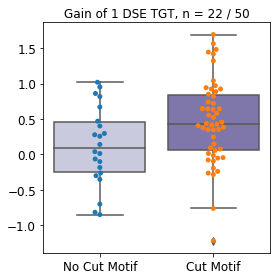

T-test Statistic = -1.2288140274982664
T-test P-value = 0.21968839192377052


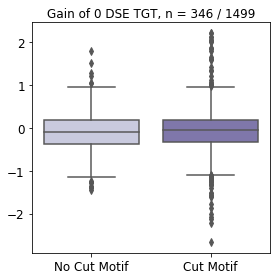

In [11]:
#Test hypothesis that creation of [G/C]T-rich motif is amplified downstream of cutsites

cut_motifs = [
    'CA',
    'GA',
    'TA',
]

has_tgt_and_no_cut_ind = []
has_tgt_and_cut_ind = []

no_tgt_and_no_cut_ind = []
no_tgt_and_cut_ind = []

for index, row in variant_df.iterrows() :
    
    ref_seq = row['wt_seq']
    var_seq = row['master_seq']
    snv_pos = row['snv_pos']
    
    ref_dse = ref_seq[56:96]
    var_dse = var_seq[56:96]
    
    has_dse_pas = False
    for pas_motif in cse_inclusion_list :
        if pas_motif in ref_dse or pas_motif in var_dse :
            has_dse_pas = True
            break
    
    #if has_dse_pas :
    #    continue
    
    if snv_pos < 56 + 15 or snv_pos > 56 + 40 :
        continue
    
    ref_dse_tgt_count = ref_dse.count("GTGT")
    var_dse_tgt_count = var_dse.count("GTGT")
    
    ref_dse_tgt_count += ref_dse.count("GTCT")
    var_dse_tgt_count += var_dse.count("GTCT")
    
    has_tgt_and_no_cut = False
    has_tgt_and_cut = False
    
    if (var_dse_tgt_count > ref_dse_tgt_count) :
        
        var_fuse = ref_seq[snv_pos-10:snv_pos-1]
        
        has_cut = False
        for cut_motif in cut_motifs :
            if cut_motif in var_fuse :
                has_cut = True
                break
        
        if has_cut :
            has_tgt_and_cut = True
        else :
            has_tgt_and_no_cut = True
    
    if has_tgt_and_cut :
        has_tgt_and_cut_ind.append(index)
    elif has_tgt_and_no_cut :
        has_tgt_and_no_cut_ind.append(index)
    
    no_tgt_and_no_cut = False
    no_tgt_and_cut = False
    
    if (var_dse_tgt_count == ref_dse_tgt_count) :
        
        var_fuse = ref_seq[snv_pos-10:snv_pos-1]
        
        has_cut = False
        for cut_motif in cut_motifs :
            if cut_motif in var_fuse :
                has_cut = True
                break
        
        if has_cut :
            no_tgt_and_cut = True
        else :
            no_tgt_and_no_cut = True
    
    if no_tgt_and_cut :
        no_tgt_and_cut_ind.append(index)
    elif no_tgt_and_no_cut :
        no_tgt_and_no_cut_ind.append(index)

has_tgt_and_no_cuts = np.array(variant_df.loc[has_tgt_and_no_cut_ind]['delta_logodds_true'].values)
has_tgt_and_cuts = np.array(variant_df.loc[has_tgt_and_cut_ind]['delta_logodds_true'].values)

no_tgt_and_no_cuts = np.array(variant_df.loc[no_tgt_and_no_cut_ind]['delta_logodds_true'].values)
no_tgt_and_cuts = np.array(variant_df.loc[no_tgt_and_cut_ind]['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[has_tgt_and_no_cuts, has_tgt_and_cuts])

sns.boxplot(data=[has_tgt_and_no_cuts, has_tgt_and_cuts], palette='Purples')

plt.xticks([0, 1], ['No Cut Motif', 'Cut Motif'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 1.1)

n_1 = has_tgt_and_no_cuts.shape[0]
n_2 = has_tgt_and_cuts.shape[0]

s, p = ttest_ind(has_tgt_and_no_cuts, has_tgt_and_cuts, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Gain of 1 DSE TGT, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_gt_rich_gain_w_cutsite_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_gt_rich_gain_w_cutsite_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[no_tgt_and_no_cuts, no_tgt_and_cuts], palette='Purples')

plt.xticks([0, 1], ['No Cut Motif', 'Cut Motif'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 1.1)

n_1 = no_tgt_and_no_cuts.shape[0]
n_2 = no_tgt_and_cuts.shape[0]

s, p = ttest_ind(no_tgt_and_no_cuts, no_tgt_and_cuts, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Gain of 0 DSE TGT, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_dse_gt_rich_gain_w_cutsite_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_dse_gt_rich_gain_w_cutsite_boxplot_null.eps")

plt.show()


In [12]:
#Save dataframe with GT-rich motif gain (nearby upstream cutsite)

variant_df.loc[has_tgt_and_cut_ind].to_csv("apa_mpra_variants_dse_gt_rich_gain_w_cutsite.csv", sep='\t', index=False)


In [40]:
#Reload variant data with upstream CSE motifs

isoform_pseudo_count = 1.
proximal_start = 57
proximal_end = 87

cse_inclusion_list = [
    'AATAAA',
    'ATTAAA',
    'TATAAA',
    'CATAAA',
    'GATAAA',
    'AGTAAA',
    'ACTAAA',
    'AATACA',
    'AATAGA',
    'AATATA',
    'AATAAT',
    'AATAAC',
    'AATAAG',
    'AATGAA',
    'AATCAA',
]

variant_df = load_data(
    isoform_pseudo_count=isoform_pseudo_count,
    proximal_start=proximal_start,
    proximal_end=proximal_end,
    cse_inclusion_list=cse_inclusion_list,
    upstream_cse_exlusion_list=[],
)


n (variants) = 10115


T-test Statistic = -2.8629418438507934
T-test P-value = 0.005413259015532524


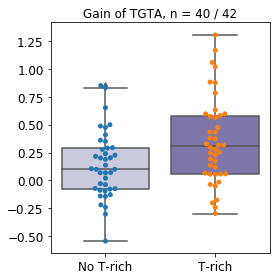

T-test Statistic = 1.1105353953604324
T-test P-value = 0.2668001511787776


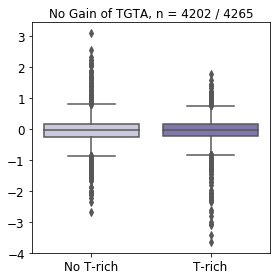

In [41]:
#Test hypothesis that gain of TGTA is amplified in PASs with a downstream T-rich motif

variant_df['ref_count_upstream_tgta'] = variant_df['wt_seq'].str.slice(0, 49).str.count("TGTA")
variant_df['var_count_upstream_tgta'] = variant_df['master_seq'].str.slice(0, 49).str.count("TGTA")

variant_df['ref_count_fdownstream_t'] = variant_df['wt_seq'].str.slice(56, 106).str.contains("TTTTT|TTATT|TATTT|TTTAT")
variant_df['var_count_fdownstream_t'] = variant_df['master_seq'].str.slice(56, 106).str.contains("TTTTT|TTATT|TATTT|TTTAT")

variant_df['ref_count_downstream_gt'] = variant_df['wt_seq'].str.slice(56, 86).str.contains("TGTGT|TGTCT")
variant_df['var_count_downstream_gt'] = variant_df['master_seq'].str.slice(56, 86).str.contains("TGTGT|TGTCT")

arr_1 = np.array(variant_df.query("(ref_count_upstream_tgta == var_count_upstream_tgta - 1) and ref_count_fdownstream_t == False and ref_count_downstream_gt == False")['delta_logodds_true'].values)
arr_2 = np.array(variant_df.query("(ref_count_upstream_tgta == var_count_upstream_tgta - 1) and ref_count_fdownstream_t == True and ref_count_downstream_gt == False")['delta_logodds_true'].values)

arr_1_null = np.array(variant_df.query("(ref_count_upstream_tgta == var_count_upstream_tgta) and ref_count_fdownstream_t == False and ref_count_downstream_gt == False")['delta_logodds_true'].values)
arr_2_null = np.array(variant_df.query("(ref_count_upstream_tgta == var_count_upstream_tgta) and ref_count_fdownstream_t == True and ref_count_downstream_gt == False")['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[arr_1, arr_2])

sns.boxplot(data=[arr_1, arr_2], palette='Purples')

plt.xticks([0, 1], ['No T-rich', 'T-rich'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 0.5)

n_1 = arr_1.shape[0]
n_2 = arr_2.shape[0]

s, p = ttest_ind(arr_1, arr_2, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Gain of TGTA, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_tgta_t_rich_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_tgta_t_rich_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[arr_1_null, arr_2_null], palette='Purples')

plt.xticks([0, 1], ['No T-rich', 'T-rich'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 0.5)

n_1 = arr_1_null.shape[0]
n_2 = arr_2_null.shape[0]

s, p = ttest_ind(arr_1_null, arr_2_null, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("No Gain of TGTA, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_tgta_t_rich_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_tgta_t_rich_boxplot_null.eps")

plt.show()


In [42]:
#Reload variant data with isoform defined only as upstream de novo cuts

isoform_pseudo_count = 1.
proximal_start = 40#57
proximal_end = 60#87

cse_inclusion_list = [
    'AATAAA',
    'ATTAAA',
    'TATAAA',
    'CATAAA',
    'GATAAA',
    'AGTAAA',
    'ACTAAA',
    'AATACA',
    'AATAGA',
    'AATATA',
    'AATAAT',
    'AATAAC',
    'AATAAG',
    'AATGAA',
    'AATCAA',
]

variant_df = load_data(
    isoform_pseudo_count=isoform_pseudo_count,
    proximal_start=proximal_start,
    proximal_end=proximal_end,
    cse_inclusion_list=cse_inclusion_list,
    upstream_cse_exlusion_list=[],
)


n (variants) = 10115


T-test Statistic = 5.013822765270237
T-test P-value = 7.4552285363293005e-06


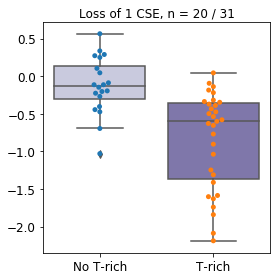

T-test Statistic = 1.080377433941542
T-test P-value = 0.2804693464778021


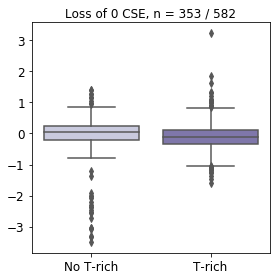

In [45]:
#Test hypothesis that T-rich motif near upstream CSE helps initiate de novo cleavage

variant_df['ref_count_upstream_cse'] = (variant_df['wt_seq'].str.slice(10, 37).str.count("AATAAA|ATTAAA|TATAAA|CATAAA|GATAAA"))
variant_df['ref_contains_upstream_t'] = (variant_df['wt_seq'].str.slice(25, 50).str.contains("TTTT|TATT|TTAT|TCTT|TTCT"))

variant_df['var_count_upstream_cse'] = (variant_df['master_seq'].str.slice(10, 37).str.count("AATAAA|ATTAAA|TATAAA|CATAAA|GATAAA"))
variant_df['var_contains_upstream_t'] = (variant_df['master_seq'].str.slice(25, 50).str.contains("TTTT|TATT|TTAT|TCTT|TTCT"))

variant_df['ref_count_fupstream_cse'] = (variant_df['wt_seq'].str.slice(0, 15).str.count("AATAAA|ATTAAA|TATAAA|CATAAA|GATAAA"))
variant_df['var_count_fupstream_cse'] = (variant_df['master_seq'].str.slice(0, 15).str.count("AATAAA|ATTAAA|TATAAA|CATAAA|GATAAA"))

loss_upstream_cse_no_t_rich = np.array(variant_df.query("ref_count_fupstream_cse == var_count_fupstream_cse == 0 and (ref_count_upstream_cse == 1 and var_count_upstream_cse == 0) and ref_contains_upstream_t == False")['delta_logodds_true'].values)
loss_upstream_cse_t_rich = np.array(variant_df.query("ref_count_fupstream_cse == var_count_fupstream_cse == 0 and (ref_count_upstream_cse == 1 and var_count_upstream_cse == 0) and ref_contains_upstream_t == True")['delta_logodds_true'].values)

loss_upstream_cse_no_t_rich_null = np.array(variant_df.query("ref_count_fupstream_cse == var_count_fupstream_cse == 0 and (ref_count_upstream_cse == var_count_upstream_cse == 1) and ref_contains_upstream_t == False")['delta_logodds_true'].values)
loss_upstream_cse_t_rich_null = np.array(variant_df.query("ref_count_fupstream_cse == var_count_fupstream_cse == 0 and (ref_count_upstream_cse == var_count_upstream_cse == 1) and ref_contains_upstream_t == True")['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[loss_upstream_cse_no_t_rich, loss_upstream_cse_t_rich])

sns.boxplot(data=[loss_upstream_cse_no_t_rich, loss_upstream_cse_t_rich], palette='Purples')

plt.xticks([0, 1], ['No T-rich', 'T-rich'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 0.5)

n_1 = loss_upstream_cse_no_t_rich.shape[0]
n_2 = loss_upstream_cse_t_rich.shape[0]

s, p = ttest_ind(loss_upstream_cse_no_t_rich, loss_upstream_cse_t_rich, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 1 CSE, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_denovo_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_denovo_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[loss_upstream_cse_no_t_rich_null, loss_upstream_cse_t_rich_null], palette='Purples')

plt.xticks([0, 1], ['No T-rich', 'T-rich'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 0.5)

n_1 = loss_upstream_cse_no_t_rich_null.shape[0]
n_2 = loss_upstream_cse_t_rich_null.shape[0]

s, p = ttest_ind(loss_upstream_cse_no_t_rich_null, loss_upstream_cse_t_rich_null, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 0 CSE, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_denovo_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_denovo_boxplot_null.eps")

plt.show()


In [48]:
#Reload variant data for CSE only

isoform_pseudo_count = 1.
proximal_start = 57#57
proximal_end = 107#87

cse_inclusion_list = [
    'AATAAA', 'ATTACA', 'ATTTAA', 'AATACA', 'AATAAG', 'ACTAAA',
    'AGTAAA', 'ATTAAA', 'GATAAT', 'AATAGA', 'ATAAAA', 'ATCAAA',
    'ATGAAA', 'ATTAAT', 'ATTAGA', 'CTTAAA', 'GTTAAA', 'TTTAAA',
    'AATTTA', 'AATAAC', 'AATCAA', 'AATTAA', 'TATAAA', 'AATAAT',
    'AATATA', 'CATAAA', 'AATGAA', 'GATAAA', 'AACAAT', 'AACAGC',
    'ACCAAC', 'AACAAA', 'AAGAAA', 'ATTATA', 'TATAGA', 'CGCTTC',
    'ATTGAA', 'AAGAAT', 'AGCAAA', 'CACTCA', 'AGTACA', 'AGTAAG',
    'CTCACA', 'AAGTAT', 'GAGGAA', 'AACGAA', 'AGTCAA', 'CATGAA', 
    'TACAAA', 'TAGAAA', 'TATAAC', 'TATAAG', 'TATAAT', 'CATAAG',
    'TATACA', 'TATATA', 'TATCAA', 'TATGAA', 'TATTAA', 'TCTAAA',
    'TGTAAA', 'AATATT', 'AATGAT', 'CTCAAG', 'AGGAAC', 'AGGTAA',
    'AATGTG', 'CATTAA', 'GATAGA', 'AATCAC', 'AAGCCA', 'AATCCG',
    'TATCCA', 'TCAATT', 'ATTATG', 'AACAAC', 'AATACC', 'ACTAAC',
    'AGTAAC', 'AAGCTG', 'AATAGT', 'AATGGG', 'TATAGG', 'AAGAAG',
    'AGCGAA', 'ATTAAG', 'AGTTAA', 'CATATA', 'AACATC', 'AATAGC',
    'ATTAAC', 'ATTCAA', 'GACGAC', 'TACGGC', 'CTACTG', 'CTGCTG',
    'CAGAAA', 'GCTAAA', 'AGGAAA', 'AGTATA', 'AACGAT', 'CATGAT',
    'GGTAAA', 'AGTAAT', 'ACTATA', 'ACCAAG', 'AGTAGA', 'CATAAT',
    'ACCACA', 'ACCTAA', 'AATGGA', 'AAGAAC', 'AATATC', 'CACAAA',
    'AATGAC', 'AATTAC', 'CATAAC', 'GATAAC', 'AACCAA', 'GATAAG',
    'ACTACA', 'AAAGAA', 'AACCAT', 'AAATCA', 'AACAGG',
]

variant_df = load_data(
    isoform_pseudo_count=isoform_pseudo_count,
    proximal_start=proximal_start,
    proximal_end=proximal_end,
    cse_inclusion_list=[],
    upstream_cse_exlusion_list=[],
)

variant_df_null = variant_df.loc[variant_df['master_seq'].str.slice(50, 56) == variant_df['wt_seq'].str.slice(50, 56)].copy()
variant_df = variant_df.loc[variant_df['master_seq'].str.slice(50, 56) != variant_df['wt_seq'].str.slice(50, 56)].copy()

variant_df_null = variant_df_null.loc[variant_df_null['wt_seq'].str.slice(50, 56).isin(cse_inclusion_list)]
variant_df_null = variant_df_null.loc[variant_df_null['master_seq'].str.slice(50, 56).isin(cse_inclusion_list)]

variant_df = variant_df.loc[variant_df['wt_seq'].str.slice(50, 56).isin(cse_inclusion_list)]
variant_df = variant_df.loc[variant_df['master_seq'].str.slice(50, 56).isin(cse_inclusion_list)]

#Load CSE hexamer regression weights
cse_weight_df = pd.read_csv("../../aparent/analysis/apa_regression_6mer_v_pasaligned_margin_doubledope_weights.csv", sep='\t')[['nmer', 'cse']].sort_values(by='cse', ascending=False)
cse_weight_df = cse_weight_df.loc[cse_weight_df['nmer'].isin(cse_inclusion_list)].query("cse != 0.0").copy().reset_index(drop=True)

variant_df['cse_ref'] = variant_df['wt_seq'].str.slice(50, 56)
variant_df['cse_var'] = variant_df['master_seq'].str.slice(50, 56)

variant_df = variant_df.join(cse_weight_df.set_index("nmer"), on='cse_ref', how='inner').rename(columns={'cse' : 'cse_ref_score'}).copy().reset_index(drop=True)
variant_df = variant_df.join(cse_weight_df.set_index("nmer"), on='cse_var', how='inner').rename(columns={'cse' : 'cse_var_score'}).copy().reset_index(drop=True)

variant_df['delta_cse_score'] = variant_df['cse_var_score'] - variant_df['cse_ref_score']

print("n (cse variants) = " + str(len(variant_df)))


n (variants) = 12350
n (cse variants) = 628


r = 0.71
p = 3.0274828217340886e-99
n = 628


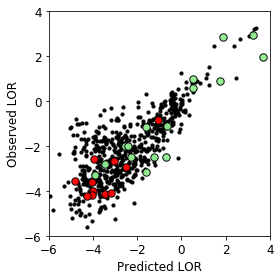

In [49]:
from scipy.stats import spearmanr

r_val, p_val = spearmanr(variant_df['delta_logodds_pred'], variant_df['delta_logodds_true'])

print("r = " + str(round(r_val, 2)))
print("p = " + str(p_val))
print("n = " + str(len(variant_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(variant_df.loc[~variant_df['significance'].isin(["Benign", "Likely benign", "Pathogenic", "Likely pathogenic"])]['delta_logodds_pred'], variant_df.loc[~variant_df['significance'].isin(["Benign", "Likely benign", "Pathogenic", "Likely pathogenic"])]['delta_logodds_true'], alpha=0.95, s=10, color='black')
plt.scatter(variant_df.loc[variant_df['significance'].isin(["Benign", "Likely benign"])]['delta_logodds_pred'], variant_df.loc[variant_df['significance'].isin(["Benign", "Likely benign"])]['delta_logodds_true'], alpha=0.95, s=55, color='lightgreen', edgecolor='black', linewidth=1)
plt.scatter(variant_df.loc[variant_df['significance'].isin(["Pathogenic", "Likely pathogenic"])]['delta_logodds_pred'], variant_df.loc[variant_df['significance'].isin(["Pathogenic", "Likely pathogenic"])]['delta_logodds_true'], alpha=0.95, s=55, color='red', edgecolor='black', linewidth=1)

plt.xlim(-6., 4.)
plt.ylim(-6., 4.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted LOR", fontsize=12)
plt.ylabel("Observed LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_var_scatter_resnet.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_var_scatter_resnet.eps")

plt.show()


T-test Statistic = -14.069639250042226
T-test P-value = 2.587053283230812e-25


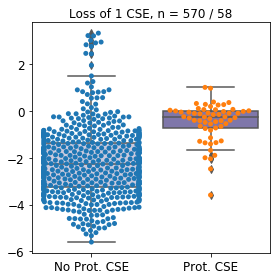

T-test Statistic = -0.11501957877265222
T-test P-value = 0.9084527799959461


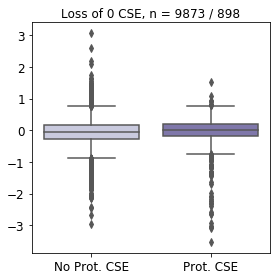

In [51]:
#Test hypothesis that nearby redundant CSEs reduces effect of LoF of main CSE

variant_df['ref_count_upstream_cse'] = variant_df['wt_seq'].str.slice(19, 49).str.count("AATAAA|ATTAAA")
variant_df['ref_count_downstream_cse'] = variant_df['wt_seq'].str.slice(56, 86).str.contains("AATAAA|ATTAAA")

variant_df_null['ref_count_upstream_cse'] = variant_df_null['wt_seq'].str.slice(19, 49).str.count("AATAAA|ATTAAA")
variant_df_null['ref_count_downstream_cse'] = variant_df_null['wt_seq'].str.slice(56, 86).str.contains("AATAAA|ATTAAA")

loss_cse_no_redundant_cse = np.array(variant_df.query("ref_count_upstream_cse == 0 and ref_count_downstream_cse == 0")['delta_logodds_true'].values)
loss_cse_redundant_cse = np.array(variant_df.query("ref_count_upstream_cse > 0 or ref_count_downstream_cse > 0")['delta_logodds_true'].values)

loss_cse_no_redundant_cse_null = np.array(variant_df_null.query("ref_count_upstream_cse == 0 and ref_count_downstream_cse == 0")['delta_logodds_true'].values)
loss_cse_redundant_cse_null = np.array(variant_df_null.query("ref_count_upstream_cse > 0 or ref_count_downstream_cse > 0")['delta_logodds_true'].values)

f = plt.figure(figsize=(4, 4))

sns.swarmplot(data=[loss_cse_no_redundant_cse, loss_cse_redundant_cse])

sns.boxplot(data=[loss_cse_no_redundant_cse, loss_cse_redundant_cse], palette='Purples')

plt.xticks([0, 1], ['No Prot. CSE', 'Prot. CSE'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 0.5)

n_1 = loss_cse_no_redundant_cse.shape[0]
n_2 = loss_cse_redundant_cse.shape[0]

s, p = ttest_ind(loss_cse_no_redundant_cse, loss_cse_redundant_cse, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 1 CSE, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_protection_boxplot.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_protection_boxplot.eps")

plt.show()

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[loss_cse_no_redundant_cse_null, loss_cse_redundant_cse_null], palette='Purples')

plt.xticks([0, 1], ['No Prot. CSE', 'Prot. CSE'], fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(-1.6, 0.5)

n_1 = loss_cse_no_redundant_cse_null.shape[0]
n_2 = loss_cse_redundant_cse_null.shape[0]

s, p = ttest_ind(loss_cse_no_redundant_cse_null, loss_cse_redundant_cse_null, equal_var=False)

print("T-test Statistic = " + str(s))
print("T-test P-value = " + str(p))

plt.title("Loss of 0 CSE, n = " + str(n_1) + " / " + str(n_2), fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_protection_boxplot_null.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_protection_boxplot_null.eps")

plt.show()


r = 0.55
p = 2.180931668873798e-50
n = 628


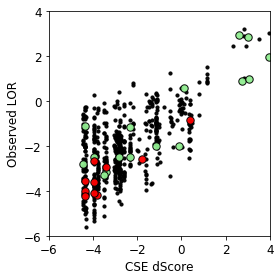

r = 0.64
p = 2.791872771762595e-73
n = 628


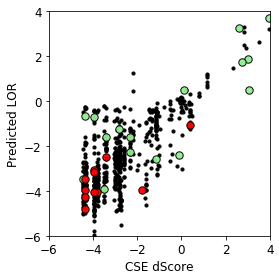

In [20]:
from scipy.stats import spearmanr

r_val, p_val = spearmanr(variant_df['delta_cse_score'], variant_df['delta_logodds_true'])

print("r = " + str(round(r_val, 2)))
print("p = " + str(p_val))
print("n = " + str(len(variant_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(variant_df.loc[~variant_df['significance'].isin(["Benign", "Likely benign", "Pathogenic", "Likely pathogenic"])]['delta_cse_score'], variant_df.loc[~variant_df['significance'].isin(["Benign", "Likely benign", "Pathogenic", "Likely pathogenic"])]['delta_logodds_true'], alpha=0.95, s=10, color='black')
plt.scatter(variant_df.loc[variant_df['significance'].isin(["Benign", "Likely benign"])]['delta_cse_score'], variant_df.loc[variant_df['significance'].isin(["Benign", "Likely benign"])]['delta_logodds_true'], alpha=0.95, s=55, color='lightgreen', edgecolor='black', linewidth=1)
plt.scatter(variant_df.loc[variant_df['significance'].isin(["Pathogenic", "Likely pathogenic"])]['delta_cse_score'], variant_df.loc[variant_df['significance'].isin(["Pathogenic", "Likely pathogenic"])]['delta_logodds_true'], alpha=0.95, s=55, color='red', edgecolor='black', linewidth=1)

plt.xlim(-6., 4.)
plt.ylim(-6., 4.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("CSE dScore", fontsize=12)
plt.ylabel("Observed LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_var_scatter_cse_score.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_var_scatter_cse_score.eps")

plt.show()

from scipy.stats import spearmanr

r_val, p_val = spearmanr(variant_df['delta_cse_score'], variant_df['delta_logodds_pred'])

print("r = " + str(round(r_val, 2)))
print("p = " + str(p_val))
print("n = " + str(len(variant_df)))

f = plt.figure(figsize=(4, 4))

plt.scatter(variant_df.loc[~variant_df['significance'].isin(["Benign", "Likely benign", "Pathogenic", "Likely pathogenic"])]['delta_cse_score'], variant_df.loc[~variant_df['significance'].isin(["Benign", "Likely benign", "Pathogenic", "Likely pathogenic"])]['delta_logodds_pred'], alpha=0.95, s=10, color='black')
plt.scatter(variant_df.loc[variant_df['significance'].isin(["Benign", "Likely benign"])]['delta_cse_score'], variant_df.loc[variant_df['significance'].isin(["Benign", "Likely benign"])]['delta_logodds_pred'], alpha=0.95, s=55, color='lightgreen', edgecolor='black', linewidth=1)
plt.scatter(variant_df.loc[variant_df['significance'].isin(["Pathogenic", "Likely pathogenic"])]['delta_cse_score'], variant_df.loc[variant_df['significance'].isin(["Pathogenic", "Likely pathogenic"])]['delta_logodds_pred'], alpha=0.95, s=55, color='red', edgecolor='black', linewidth=1)

plt.xlim(-6., 4.)
plt.ylim(-6., 4.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("CSE dScore", fontsize=12)
plt.ylabel("Predicted LOR", fontsize=12)

plt.tight_layout()

plt.savefig("apa_mpra_variants_cse_var_scatter_cse_score_resnet.png", dpi=300, transparent=True)
plt.savefig("apa_mpra_variants_cse_var_scatter_cse_score_resnet.eps")

plt.show()


In [81]:
#Save filtered CSE variant dataframe with CSE regression weights cached

variant_df.to_csv("apa_cse_variant_data_filtered.csv", sep='\t', index=False)
